# Liquid Clustering Performance Benchmark

Databricks introduced [Liquid Clustering](https://learn.microsoft.com/en-us/azure/databricks/delta/clustering) back in [June 2023](https://www.databricks.com/blog/announcing-delta-lake-30-new-universal-format-and-liquid-clustering). The feature is intend to replace table partition and z-order, making perfomance tuning on Delta table easier. Databricks cites a 2.5x increase on point queries on liquid clustered tables.

In this benchmark, we will use real queries in the data lake to compare if liquid cluster will provide improvements in our query performance.

In [ ]:
import re
import time
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

sns.set_style("ticks")


## Preparation

We choose `SELECT` queries from Cosmos on the `telemetry_v1` table as our samples. We will use queries from 2023-11-20 to 2023-11-26, with duplicated queries remove, to run the benchmark. (See `liquid_cluster_benchmark/query_history.py` for how we collected the samples.)

In [ ]:
rng = np.random.default_rng(69420)


class Samples:
    def __init__(self, file_path, top=None):
        queries = Path(file_path).read_text().split("\n")
        top = top or len(queries)
        self.queries = queries[:top]

    def __len__(self):
        return len(self.queries)

    def shuffle(self):
        rng.shuffle(self.queries)

    @property
    def classic(self):
        for query in self.queries:
            query.replace("cn_charger", "test_ds2023q4").replace(
                "telemetry_v1", "telemetry_v1_classic"
            )
            yield query

    @property
    def liquid(self):
        for query in self.queries:
            query.replace("cn_charger", "test_ds2023q4").replace(
                "telemetry_v1", "telemetry_v1_liquid"
            )
            yield query


samples = Samples("/Workspace/Users/david.chu@wallbox.com/queries.txt")
samples.shuffle()
print("Number of examples:", len(samples))


Number of examples: 1759


The benchmark will be run on two tables:

* `telemetry_v1_classic` mimics our production CN telemetry_v1 table. It is partitioned by `besiness_date` and z-ordered by `charger_id`.
* `telemetry_v1_liquid` uses liquid clustering on `charger_id` and `besiness_date`. According to the document, the order of cluster column doesn't matter.

Both table have the same data, 34,146,652,534 rows from `dataprod.cn_charger.telemetry_v1` bewtween 20231120 and 20231127. (See `liquid_cluster_benchmark/create_test_data.sql` for how we created the tables.) 73% or 1,285 

In [ ]:
%sql
DESCRIBE DETAIL datadev.test_ds2023q4.telemetry_v1_classic


format,id,name,description,location,createdAt,lastModified,partitionColumns,numFiles,sizeInBytes,properties,minReaderVersion,minWriterVersion,tableFeatures,statistics
delta,29f5aaef-76cf-42a8-b432-bc1ef11c1946,datadev.test_ds2023q4.telemetry_v1_classic,null,s3://wallbox-datalake-sv-datadev/test_ds2023q4/telemetry_v1_classic/successful/1/part1,2023-11-29T11:08:43.684+0000,2023-11-29T12:23:58.000+0000,List(business_date),10220,4989020805525,"Map(delta.checkpoint.writeStatsAsStruct -> true, delta.checkpoint.writeStatsAsJson -> false)",1,2,"List(appendOnly, invariants)",Map()


In [ ]:
%sql
DESCRIBE DETAIL datadev.test_ds2023q4.telemetry_v1_liquid


---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
File <command-1510586113217814>:7
      5     display(df)
      6     return df
----> 7   _sqldf = ____databricks_percent_sql()
      8 finally:
      9   del ____databricks_percent_sql

File <command-1510586113217814>:4, in ____databricks_percent_sql()
      2 def ____databricks_percent_sql():
      3   import base64
----> 4   df = spark.sql(base64.standard_b64decode("REVTQyBkYXRhZGV2LnRlc3RfZHMyMDIzcTQudGVsZW1ldHJ5X3YxX2xpcXVpZA==").decode())
      5   display(df)
      6   return df

File /databricks/spark/python/pyspark/instrumentation_utils.py:48, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     46 start = time.perf_counter()
     47 try:
---> 48     res = func(*args, **kwargs)
     49     logger.log_success(
     50         module_name, class_name, function_name, time.perf_counter() - start, signature
     51     )
     52

Remove queries out of our table data range.

In [ ]:
START_DATE = re.compile(r"business_date [>][=] [\"'](\d+)['\"]")
DATE_RANGE = [
    "20231120",
    "20231121",
    "20231122",
    "20231123",
    "20231124",
    "20231125",
    "20231126",
    "20231127",
]


def in_range(query):
    matched = START_DATE.search(query)
    return matched and matched.group(1) in DATE_RANGE


samples.queries = [q for q in samples.queries if in_range(q)]
print("Number of examples:", len(samples))


Number of examples: 977


## Query Runs

The benchmark is run on a 1-worker r6gd.large cluster using Databricks Runtime 12.2 (Scala 2.12, Spark 3.3.2.) Thie version doesn't support row-level concurrency.

The order of execution is randomised to ensure a fair comparison.

In [ ]:
def execute(query):
    """Return the execution time of the query in millisecond."""
    res = spark.sql(query)
    start = time.monotonic()
    res.collect()
    end = time.monotonic()
    return (end - start) * 1000


def benchmark(a, b):
    if rng.random() >= 0.5:
        time_a = execute(a)
        time_b = execute(b)
    else:
        time_b = execute(b)
        time_a = execute(a)
    return [time_a, time_b]


# Remove the first run because the cluster was warming up.
durations = [benchmark(cla, liq) for cla, liq in zip(samples.classic, samples.liquid)][
    1:
]


## Result

We will show the difference between classic partition's and liquid clustering's query time by ploting their distribution.

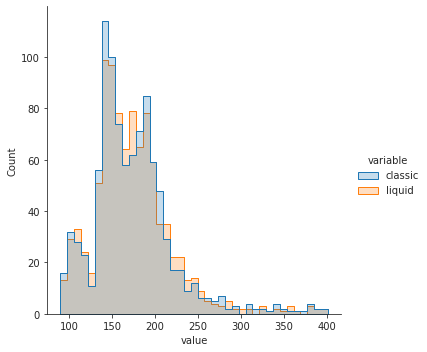

In [ ]:
df = pd.DataFrame(durations, columns=["classic", "liquid"])

sns.displot(
    pd.melt(df, value_vars=["classic", "liquid"]),
    x="value",
    hue="variable",
    element="step",
)
sns.despine()


And confirm the result by running a pairwise T-test.

In [ ]:
desc = f"""\
                    Mean    Std
Classic Partition:  {df["classic"].mean():.1f}   {df["classic"].std():.3f}
Liquid Clustering:  {df["liquid"].mean():.1f}   {df["liquid"].std():.3f}

P-value: {stats.ttest_rel(df["classic"], df["liquid"]).pvalue:.3f}
"""

print(desc)


                    Mean    Std
Classic Partition:  173.4   47.810
Liquid Clustering:  173.6   46.405

P-value: 0.899

